In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# from jax import config
# config.update("jax_enable_x64", True)

## Constants

In [3]:
X_START = 0
X_END = 1
T_START = 0
T_END = 0.25
NX = 200
NT = int((T_END - T_START)/0.0001)
ALPHA = 1./jnp.pi**2

## Space-Time Domain

In [4]:
x = jnp.linspace(X_START, X_END, NX + 1)
dx = x[1] - x[0]

t = jnp.linspace(T_START, T_END, NT + 1)
dt = t[1] - t[0]

In [5]:
beta = dt / dx

## Initial Conditions

In [6]:
u = jnp.sin(2. * jnp.pi * x)

## Helper functions

In [7]:
# weights for reconstructor on the left side
@jax.jit
def crwcL(u_sliced):
    eps = 1e-6
    v1, v2, v3, v4, v5 = u_sliced
    
    s1 = (13. / 12.) * (v1 - 2. * v2 + v3)**2 + 0.25 * (v1 - 4. * v2 + 3. * v3)**2
    s2 = (13. / 12.) * (v2 - 2. * v3 + v4)**2 + 0.25 * (v2 - v4)**2
    s3 = (13. / 12.) * (v3 - 2. * v4 + v5)**2 + 0.25 * (3. * v3 - 4. * v4 + v5)**2
    
    c1 = 2e-1/(eps + s1)**2
    c2 = 5e-1/(eps + s2)**2
    c3 = 3e-1/(eps + s3)**2
    
    c_sum = c1 + c2 + c3
    
    w1 = c1/c_sum
    w2 = c2/c_sum
    w3 = c3/c_sum
    
    a1 = (2. * w1 + w2)/ 3.
    a2 = (w1 + 2. * w2 + 2. * w3)/3.
    a3 = w3/3.
    
    b1 = w1/6.
    b2 = (5. * w1 + 5. * w2 + w3)/6.
    b3 = (w2 + 5. * w3)/6.
    
    return jnp.asarray((a1, a2, a3, b1, b2, b3))


## weights for reconstructor on the right side
@jax.jit
def crwcR(u_sliced):
    eps = 1e-6
    v1, v2, v3, v4, v5 = u_sliced
    
    s1 = (13. / 12.) * (v1 - 2. * v2 + v3)**2 + 0.25 * (v1 - 4. * v2 + 3. * v3)**2
    s2 = (13. / 12.) * (v2 - 2. * v3 + v4)**2 + 0.25 * (v2 - v4)**2
    s3 = (13. / 12.) * (v3 - 2. * v4 + v5)**2 + 0.25 * (3. * v3 - 4. * v4 +  v5)**2
    
    c1 = 3e-1/(eps + s1)**2
    c2 = 5e-1/(eps + s2)**2
    c3 = 2e-1/(eps + s3)**2
    
    c_sum = c1 + c2 + c3
    
    w1 = c1/c_sum
    w2 = c2/c_sum
    w3 = c3/c_sum
    
    a1 = w1/3. 
    a2 = (w3 + 2. * (w2 + w1))/3. 
    a3 = (2. * w3 + w2)/3.
    
    b1 = (w2 + 5. * w1)/6.
    b2 = (5. * (w3 + w2) + w1)/6.
    b3 = w3/6.
     
    return jnp.asarray((a1, a2, a3, b1, b2, b3))


In [8]:
@jax.jit
def crwenoL_pre(u, xs, index):    
    def u_slices(index, x):
        def case_1(index, u): 
            return crwcL(jnp.asarray([u[-3], u[-2], u[0], u[1], u[2]]))
        def case_2(index, u):
            return crwcL(jnp.asarray([u[-2], u[0], u[1], u[2], u[3]]))
        def case_N(index, u):
            return crwcL(jnp.asarray([u[-4], u[-3], u[-2], u[-1], u[1]]))
        def normal(index, u):
            return crwcL(jax.lax.dynamic_slice_in_dim(u, index - 2, 5))
        return jax.lax.switch(x, (normal, case_1, case_2, case_N), index, u)
    
    return u_slices(index, xs)

@jax.jit
def crwenoR_pre(u, xs, index):    
    def u_slices(index, x):
        def case_1(index, u):
            return crwcR(jnp.asarray([u[-2], u[0], u[1], u[2], u[3]]))
        def case_N(index, u):
            return crwcR(jnp.asarray([u[-4], u[-3], u[-2], u[-1], u[1]]))
        def case_N_p_1(index, u):
            return crwcR(jnp.asarray([u[-3], u[-2], u[-1], u[1], u[2]]))
        def normal(index, u):
            return crwcR(jax.lax.dynamic_slice_in_dim(u, index - 1, 5))
        return jax.lax.switch(x, (normal, case_1, case_N, case_N_p_1), index, u)
    
    return u_slices(index, xs)

In [9]:
crwenoL_pre_mapped = jax.vmap(crwenoL_pre, in_axes=(None, 0, 0), out_axes=1)
crwenoR_pre_mapped = jax.vmap(crwenoR_pre, in_axes=(None, 0, 0), out_axes=1)

In [10]:
@jax.jit
def crwenoL(u, xsL, u_index_arr, periodic_index_arr, empty_row):

    coeff_slices = crwenoL_pre_mapped(u, xsL, u_index_arr)
    a1, a2, a3, b1, b2, b3 = coeff_slices
    
    row_size = empty_row.size 

    def filling_A(loc_index, empty_row):
        a1_loc, a2_loc, a3_loc = loc_index % row_size, (loc_index + 1) % row_size, (loc_index + 2) % row_size 
        return empty_row.at[jnp.asarray([a1_loc, a2_loc, a3_loc])].set((a1[a2_loc], a2[a2_loc], a3[a2_loc]))
          
    A = jax.vmap(filling_A, in_axes=(0, None))(periodic_index_arr, empty_row)
    
    b = empty_row.at[0].set(b1[0] * u[-2] + b2[0] * u[0] + b3[0] * u[1])
    b = b.at[1:].set(jax.lax.slice_in_dim(b1, 1, None) * jax.lax.slice_in_dim(u, 0, -2) + jax.lax.slice_in_dim(b2, 1, None) * jax.lax.slice_in_dim(u, 1, -1) + jax.lax.slice_in_dim(b3, 1, None) * jax.lax.slice_in_dim(u, 2, None))
    
    return jax.scipy.linalg.solve(A, b)

@jax.jit
def crwenoR(u, xsR, u_index_arr, periodic_index_arr, empty_row):

    coeff_slices = crwenoR_pre_mapped(u, xsR, u_index_arr)
    a1, a2, a3, b1, b2, b3 = coeff_slices
    
    row_size = empty_row.size 
    
    def filling_A(loc_index, empty_row):
            a1_loc, a2_loc, a3_loc = loc_index % row_size, (loc_index + 1) % row_size, (loc_index + 2) % row_size 
            return empty_row.at[jnp.asarray([a1_loc, a2_loc, a3_loc])].set((a1[a2_loc], a2[a2_loc], a3[a2_loc]))
             
    A = jax.vmap(filling_A, in_axes=(0, None))(periodic_index_arr, empty_row)
    
    b = empty_row.at[-1].set(b1[-1] * u[-2] + b2[-1] * u[-1] + b3[-1] * u[1])
    b = b.at[0:-1].set(jax.lax.slice_in_dim(b1, 0, -1) * jax.lax.slice_in_dim(u, 0, -2) + jax.lax.slice_in_dim(b2, 0, -1) * jax.lax.slice_in_dim(u, 1, -1) + jax.lax.slice_in_dim(b3, 0, -1) * jax.lax.slice_in_dim(u, 2, None))
    
    return jax.scipy.linalg.solve(A, b)

In [11]:
@jax.jit
def rhs(u, beta, xsL, xsR, u_index_arr, periodic_index_arr, empty_row):
    uL = crwenoL(u, xsL, u_index_arr, periodic_index_arr, empty_row)
    uR = crwenoR(u, xsR, u_index_arr, periodic_index_arr, empty_row)
    
    flux_L = -beta * jax.lax.slice_in_dim(u, 1, -1) * (jax.lax.slice_in_dim(uL, 1, None) - jax.lax.slice_in_dim(uL, 0, -1))
    flux_R = -beta * jax.lax.slice_in_dim(u, 1, -1) * (jax.lax.slice_in_dim(uR, 1, None) - jax.lax.slice_in_dim(uR, 0, -1))
    
    def flux_L_at_each_step(u_i):
        return jax.lax.cond(u_i >= 0.0, lambda: 1. , lambda: 0.)
    
    choose_flux_L = jax.vmap(flux_L_at_each_step)(u[1:-1])
    choose_flux_R = 1. - choose_flux_L
    
    return choose_flux_L * flux_L + choose_flux_R * flux_R

In [12]:
@partial(jax.jit, static_argnames=('NX', 'NT'))
def crweno5_num_loop(u, beta, NX, NT):
    
    xsL = jnp.zeros(NX, dtype=jnp.int32)
    xsL = xsL.at[jnp.asarray((0, 1, NX - 1))].set((1, 2, 3))
    
    xsR = jnp.zeros(NX, dtype=jnp.int32)
    xsR = xsR.at[jnp.asarray((0, NX - 2, NX - 1))].set((1, 2, 3))
    
    u_index_arr = jnp.arange(0, NX, dtype=jnp.int32)
    periodic_index_arr = jnp.arange(NX - 1, 2*NX - 1, dtype=jnp.int32)
    empty_row = jnp.zeros(NX)    
    
    def u_each_time_step(u_i, _):
        ## RK3 time integration
        slice_x_1 = jax.lax.slice_in_dim(u_i, 1, NX)
        u1 = jnp.zeros(NX + 1)
        
        r = rhs(u_i, beta, xsL, xsR, u_index_arr, periodic_index_arr, empty_row)
        u1 = u1.at[1:NX].set(slice_x_1 + r)

        r = r.at[:].set(rhs(u1, beta, xsL, xsR, u_index_arr, periodic_index_arr, empty_row))
        u1 = u1.at[1:NX].set(0.75*slice_x_1 + 0.25*(jax.lax.slice_in_dim(u1, 1, NX) + r))

        r = r.at[:].set(rhs(u1, beta, xsL, xsR, u_index_arr, periodic_index_arr, empty_row))
        u_i = u_i.at[1:NX].set((1./3.)*slice_x_1 + (2./3.)*(jax.lax.slice_in_dim(u1, 1, NX) + r))
        #u_i = u_i.at[bc].set(0)
        
        return u_i, u_i
    
    return jax.lax.scan(u_each_time_step, u, None, NT)
    

In [13]:
_, U = crweno5_num_loop(u, beta, NX, NT)

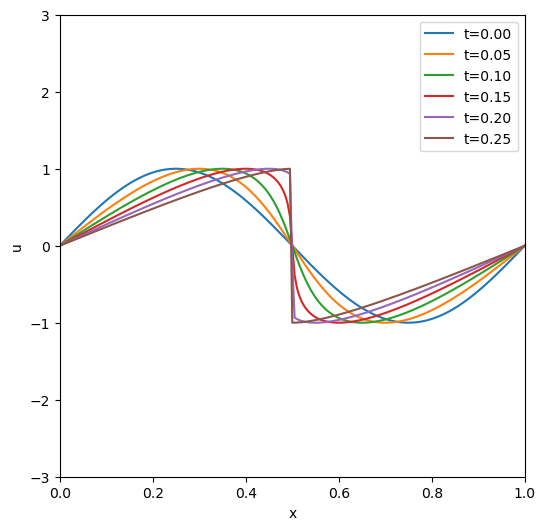

In [14]:
plt.figure(figsize=(6,6))
plt.xlabel("x")
plt.ylabel("u")
plt.xlim((0,1))
plt.ylim((-3,3))
#plt.title("Comparison of theoritical and numerical values @ t = 1")
for i in range(0, NT + 500, 500):    
    plt.plot(x, U[i], label=f't={(i*dt):2.2f}')
plt.legend()
plt.show()